# Tutorial: Cell Development Trajectory Inference
In this tutorial, we'll use BRICK to interpret cell development trajectory.

In [1]:
import sys
import os
import scanpy as sc
from scipy.sparse.csgraph import connected_components
import numpy as np
import scipy.sparse
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import itertools

import BRICK

import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42

## Configure your LLM

In [2]:
#base_url = ""
#api_key = ""

api_key = "sk-kpsteSkpDGl1xBmDEcC7D51b968e43499092826f17286b55"
base_url = "http://10.224.28.80:3000/v1"
llm_params = {"model_name": "deepseek-v3-hs", "temperature": 0.7}

BRICK.config_llm(modeltype='ChatOpenAI', base_url=base_url, api_key=api_key, llm_params=llm_params)

LLM has been configured and initialized successfully.


## Configure your Knowledge Graph

In [5]:
#url = ""
#auth = ("user_name", "password")  

url = "neo4j://10.224.28.66:7687"
auth = ("neo4j", "bmVvNGpwYXNzd29yZA==")  

BRICK.config(url=url, auth=auth)

Graph database has been configured and initialized successfully.


## Calculate Cell Development Trajectory
Here we use scanpy.tl.paga() to obtain our cell development trajectory. \
We have preprocessed our Anndata by following the scanpy tutorial.

In [6]:
adata = sc.read_h5ad("./data/processed_wbc_m_group1.h5ad") # you can use your Anndata
adata

AnnData object with n_obs × n_vars = 19869 × 2000
    obs: 'organism_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'suspension_type', 'author_experimental_id', 'author_day', 'author_somite_count', 'author_major_cell_cluster', 'author_cell_type', 'tissue_type', 'is_primary_data', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes', 'leiden', 'paga_cluster'
    var: 'gene_short_name', 'chr', 'start', 'end', 'strand', 'gene_type', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'author_day_colors', 'author_somite_count_colors', 'cell_type_colors', 'cell_type_sizes', 'citati

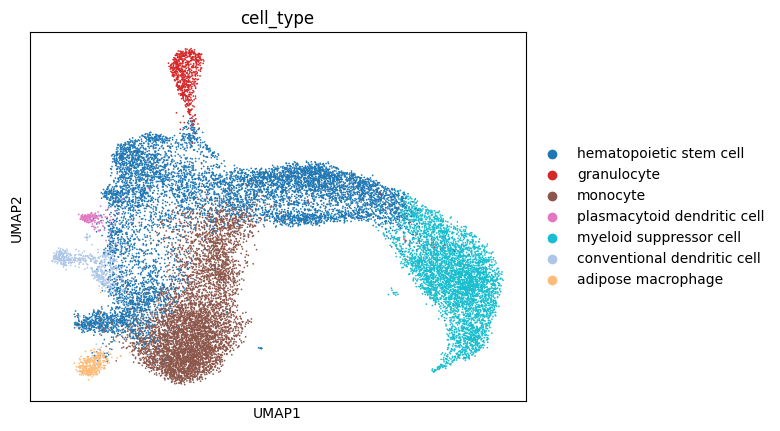

In [7]:
sc.pl.umap(adata,color="cell_type")

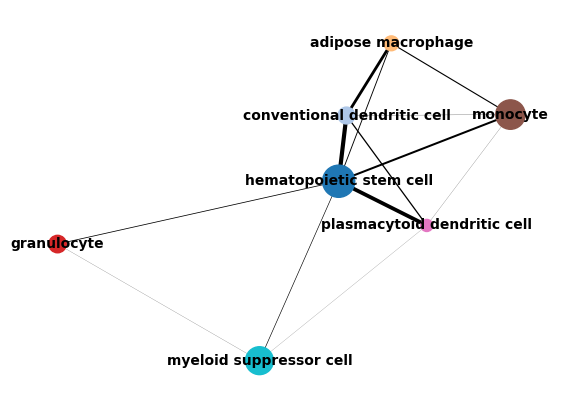

In [8]:
sc.tl.paga(adata, groups='cell_type')
sc.pl.paga(adata, frameon=False)

## Optional: ask LLM for your next step

In [9]:
question = "What should I do in next step with this adata after running paga."
result = BRICK.inp.paga_adviser(adata, question)
print("Generated Answer:", result)

Now generating answer ... 

Generated Answer: Based on the provided data and the connectivities matrix from your AnnData object, it's evident that you are examining the cell development trajectory graph using PAGA (Partition-based Graph Abstraction). The connectivities data in `adata.uns['paga']['connectivities_tree']` indicates the strength of connections between different cell groups. Here are some observations and suggestions for your next steps:

### Analysis of Connectivities Data
The connectivities matrix shows the strength of connections between different clusters (or groups) of cells. The values range from 0 to 0.3988802, with higher values indicating stronger connections. Notably, the strongest connections are between cluster 0 and clusters 3 (0.36568368) and 5 (0.3988802). Additionally, there is a significant connection between cluster 5 and cluster 6 (0.2709588). The rest of the connections are either weak or non-existent, as indicated by the zeros in the matrix.

### Sugges

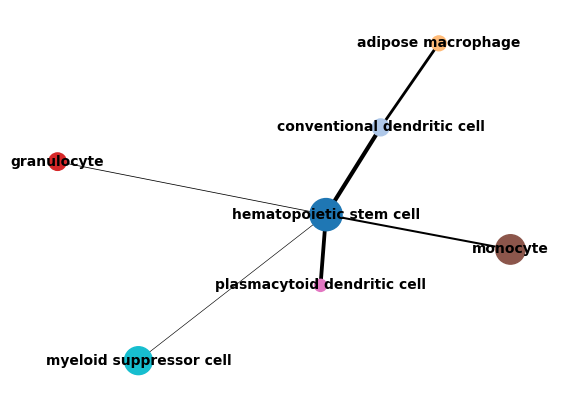

In [10]:
sc.pl.paga(adata, solid_edges='connectivities_tree', threshold=0.05, frameon=False)

## Visualize your paga trajectory by BRICK.pp.paga2nx
You can use different functions to visualize your graph and save it in various formats. \
Here we show an example of static graph, all paths calculated by paga are considered unverified.

d:\downloads\nlp\kg_repo\BRICK\preprocess.py:331: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  name2size = tmp.groupby(group).count().to_dict()['0']


Graph saved to ./paga.svg


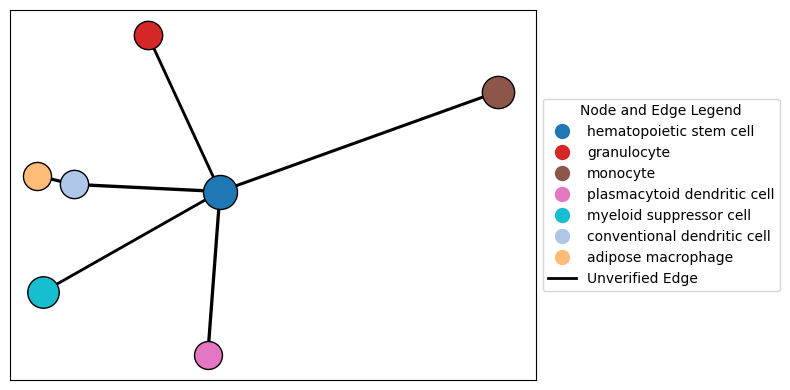

In [12]:
G = BRICK.pp.paga2nx(adata)
#BRICK.pl.interact_visualize_network(G, node_label = 'original_name',notebook=False, save="./paga.html")
BRICK.pl.static_visualize_network(G, save_path="./paga.svg")
#BRICK.pp.save_graph(G,"./paga2.svg")

## Specific steps to search nodes
Here we use specific functions to search all paga nodes in our knowledge graph, you can use you own function.

## Visualization
To visualize our new graph in static state, we can use different layout, such as "spring", "tree", "circular", "kamada_kawai", "shell", "spectral". The layout "tree" will be recommend. \
You can also use the BRICK.pp.save_graph() function with the 'svg' or 'pdf' format, the layout closely resembles a 'tree'.

Graph saved to ./final_G_tree.svg


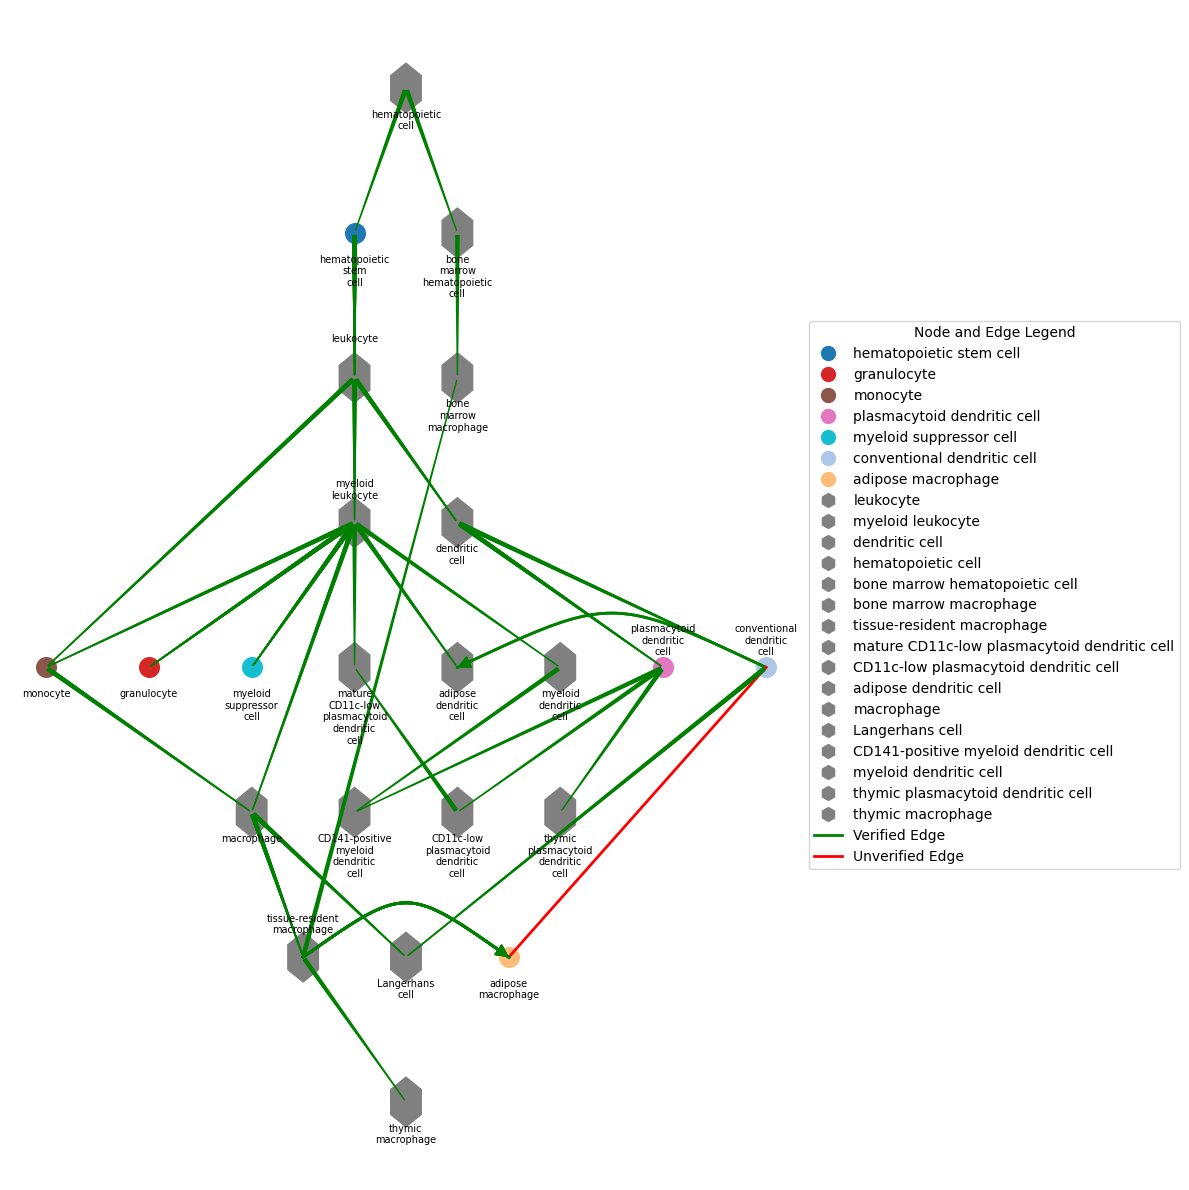

In [20]:
all_paths = []
for source, target in itertools.combinations(G.nodes, 2):
    qg = BRICK.qr.query_shortest_path(
        source_entity_name=source,
        target_entity_name=target,
        source_entity_type="Cell",
        target_entity_type="Cell",
        relation="is_a|develope_into",
        multi_hop=(1,10),
        return_type='graph'
    )
    
    processed_paths = BRICK.pp.filter_results(qg)
    
    all_paths.extend(processed_paths)

nx_new_paga = BRICK.pp.complete_results(
    filtered_paths=all_paths,
    original_graph=G,
    node_attrs={'color':'gray', 'shape':'hexagon', 'size':12},
    edge_attrs={'color':'green', 'weight':8, 'arrows':'to'}
)

BRICK.pl.static_visualize_network(nx_new_paga,figsize=(12,12),layout="tree",node_scale_factor=70,frameon=False,save_path="./final_G_tree.svg") 

## Interpret general cell development trajectory path
Now, we can use LLM model to interpret our general cell development trajectory

In [21]:
result = BRICK.inp.analyse_general_trajectory(nx_new_paga)
print("Generated Answer:", result)

Generated Answer: The provided cell development trajectory graph offers a comprehensive view of the hierarchical and branching pathways of hematopoietic cell differentiation, integrating both experimental RNAseq data and established biological knowledge. At the core of this graph lies the **hematopoietic stem cell (HSC)**, a multipotent progenitor that gives rise to a diverse array of cell types, including leukocytes, monocytes, and dendritic cells. The repeated green edges from HSC to **leukocyte** highlight the fundamental role of leukocytes as a primary lineage derived from HSCs, with further differentiation into **myeloid leukocytes** and **monocytes**. This trajectory is governed by key regulatory genes such as **PU.1** and **GATA2**, which orchestrate the commitment to myeloid lineages, and signaling pathways like **Notch** and **Wnt**, which ensure proper lineage specification. The **myeloid leukocyte** node serves as a critical branching point, giving rise to **granulocytes** a

## Interpret specific cell development trajectory path
We can also use LLM model to interpret one specific trajectory path

In [22]:

source_node = "hematopoietic stem cell"

target_node = "adipose macrophage"

result = BRICK.inp.analyse_specific_trajectory(nx_new_paga,source_node,target_node)
print("Generated Answer:", result)

Generated Answer: ### Analysis of the Developmental Path from Hematopoietic Stem Cell to Adipose Macrophage

#### Overview of the Developmental Path
The trajectory from **hematopoietic stem cell (HSC)** to **adipose macrophage** involves multiple intermediate cell types and developmental stages. Based on the provided trajectory paths, the developmental relationship can be represented as follows:  
**Hematopoietic stem cell → Leukocyte → Myeloid leukocyte → Monocyte → Macrophage → Tissue-resident macrophage → Adipose macrophage**.  

This path is represented by green trajectories in the graph, indicating that these developmental relationships are supported by existing knowledge. However, one exception is the direct transition from **conventional dendritic cell** to **adipose macrophage**, which is marked in red. This pathway was calculated by PAGA (Partition-based Graph Abstraction) but has not been experimentally verified. Further exploration, such as gene regulatory network analysis, 